In [1]:
# IGNORE THIS CELL WHICH CUSTOMIZES LAYOUT AND STYLING OF THE NOTEBOOK !
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names, but [a-zA-Z]+ was fitted with feature names", category=UserWarning)
                                  
warnings.filterwarnings = lambda *a, **kw: None
from IPython.core.display import HTML

HTML(open("custom.html", "r").read())

# Chapter 6: An overview of classifiers, Part 1

<span style="font-size: 150%;">Nearest Neighbors and linear-based methods</span>

This script gives a quick hands-on overview of **how different types of classifiers work, their advantages and their disadvantages**. This should give you an idea of a concept behind each classifier type as well as when and which classifier type to use.

For the sake of visualisation we continue with 2 dimensional data examples. For different classifiers we'll be looking at their decision surfaces. Let's start with some helper functions for that:

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def samples_color(ilabels, colors=["steelblue", "chocolate"]):
    """Return colors list from labels list given as indices."""
    return [colors[int(i)] for i in ilabels]


def plot_decision_surface(
    features_2d,
    labels,
    classifier,
    preprocessing=None,
    plt=plt,
    marker=".",
    N=100,
    alpha=0.2,
    colors=["steelblue", "chocolate"],
    title=None,
    test_features_2d=None,
    test_labels=None,
    test_s=60,
):
    """Plot a 2D decision surface for a already trained classifier."""

    # sanity check
    assert len(features_2d.columns) == 2

    # pandas to numpy array; get min/max values
    xy = np.array(features_2d)
    min_x, min_y = xy.min(axis=0)
    max_x, max_y = xy.max(axis=0)

    # create mesh of NxN points; tech: `N*1j` is spec for including max value
    XX, YY = np.mgrid[min_x : max_x : N * 1j, min_y : max_y : N * 1j]
    points = np.c_[XX.ravel(), YY.ravel()]  # shape: (N*N)x2
    # points = pd.DataFrame(points, columns=["x", "y"])

    # apply scikit-learn API preprocessing
    if preprocessing is not None:
        points = preprocessing.transform(points)

    # classify grid points
    classes = classifier.predict(points)

    # plot classes color mesh
    ZZ = classes.reshape(XX.shape)  # shape: NxN
    plt.pcolormesh(
        XX,
        YY,
        ZZ,
        alpha=alpha,
        cmap=matplotlib.colors.ListedColormap(colors),
        shading="auto",
    )
    # plot points
    plt.scatter(
        xy[:, 0],
        xy[:, 1],
        marker=marker,
        color=samples_color(labels, colors=colors),
    )
    # set title
    if title:
        if hasattr(plt, "set_title"):
            plt.set_title(title)
        else:
            plt.title(title)
    # plot test points
    if test_features_2d is not None:
        assert test_labels is not None
        assert len(test_features_2d.columns) == 2
        test_xy = np.array(test_features_2d)
        plt.scatter(
            test_xy[:, 0],
            test_xy[:, 1],
            s=test_s,
            facecolors="none",
            linewidths=2,
            color=samples_color(test_labels),
        );

Since the latest version, `sklearn` offers its own method for visualizing decision boundaries: `DecisionBoundaryDisplay`. Documentation for this method can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html.

## Nearest Neighbors

The idea is very simple: to classify a sample $x$ look for **$N$ closest samples in the training data** (by default, using the Euclidean distance) and take **majority of their labels** as a result.

This method does well where the fast linear classifiers would fail, such as with the XOR dataset:

In [3]:
import pandas as pd


df = pd.read_csv("data/xor.csv")
df.head(2)

x         y  label
0 -1.539782  0.950822   True
1  0.436266 -1.768324   True

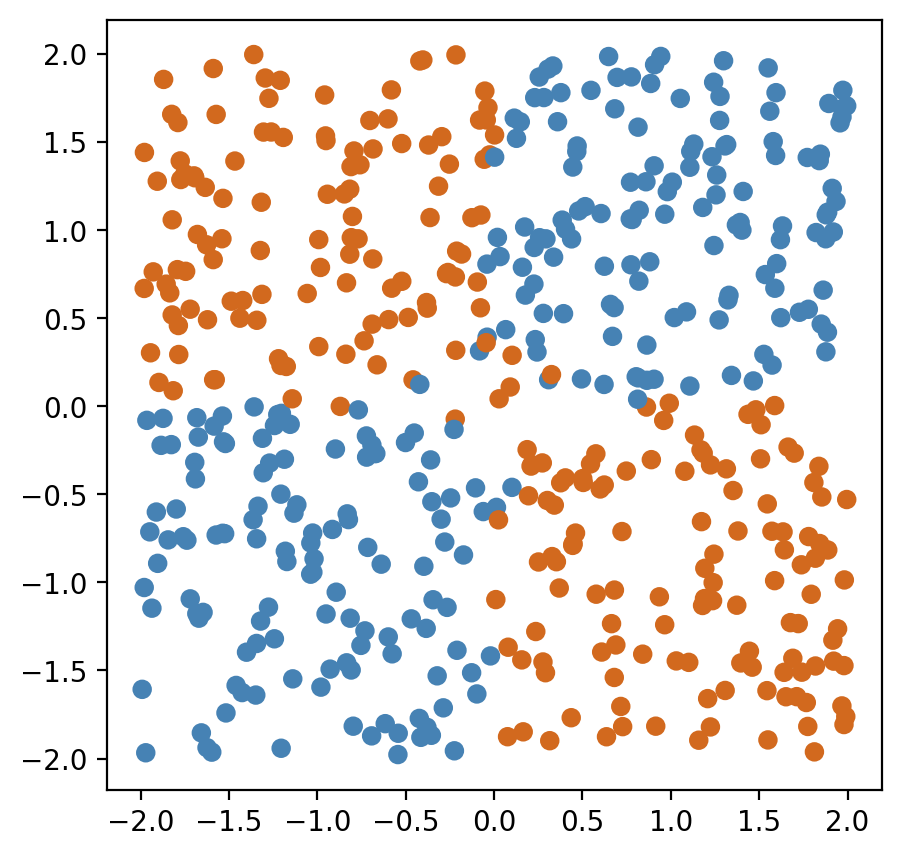

In [4]:
features_2d = df.loc[:, ("x", "y")]
labelv = df["label"]

plt.figure(figsize=(5, 5))
plt.scatter(features_2d.iloc[:, 0], features_2d.iloc[:, 1], color=samples_color(labelv));

You will find the Nearest Neighbors method in the `sklearn.neighbors` module.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


X_train, X_test, y_train, y_test = train_test_split(
    features_2d, labelv, random_state=10
)
X_train

x         y
324 -1.626442  0.916387
252 -0.215871  1.994580
441 -1.223902 -0.047145
427 -0.721214 -0.288944
70   0.352416 -0.882718
..        ...       ...
320 -0.040543  0.806787
15  -1.115884 -0.559744
484  1.243760  0.912272
125 -0.662044  0.235050
265  0.225206  0.693330

[375 rows x 2 columns]

train score: 97.33%
test score: 93.60%


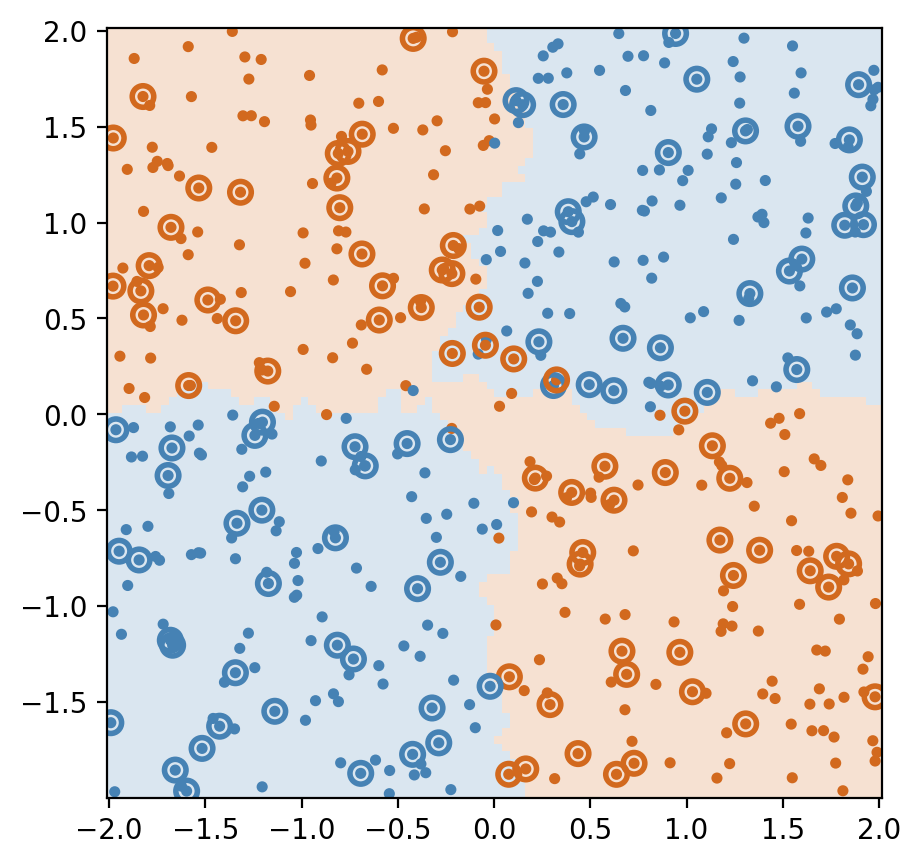

In [6]:
# Let's use 5 neighbors to learn
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

print("train score: {:.2f}%".format(100 * classifier.score(X_train, y_train)))
print("test score: {:.2f}%".format(100 * classifier.score(X_test, y_test)))

plt.figure(figsize=(5, 5))
plot_decision_surface(
    features_2d,
    labelv,
    classifier,
    test_features_2d=X_test,
    test_labels=y_test,
)

About the plot: **the points surrounded with a circle are from the test data set** (not used for learning), all other points belong to the training data.

We can query directly for the closest neighbors of a point. Let's check neighborhood of the origin:

In [7]:
# distances and row indices of neighbours around (0, 0):
dist_nn, ind_nn = classifier.kneighbors([[0, 0]])

# tech: simplify dimensions
ind_nn = ind_nn.squeeze()
dist_nn = dist_nn.squeeze()

# build data frame with neighbours
df = X_train.iloc[ind_nn, :].copy()
df["label"] = y_train.iloc[ind_nn]
df["dist"] = dist_nn
df

x         y  label      dist
496  0.028310  0.042214   True  0.050828
137  0.091190  0.109028   True  0.142137
51  -0.219754 -0.073249   True  0.231641
194  0.186789 -0.246576   True  0.309338
216 -0.082451  0.314070  False  0.324712

### Exercise section

Load the beers dataset and experiment with a number of neighbors (`n_neighbors`) as well as with the Manhattan distance norm `p = 1` (`2` is Euclidian distance).

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("data/beers.csv")
features = df.iloc[:, :-1]
labelv = df.iloc[:, -1]

n_neighbors_values = [2, 3, 5, 10, 20]
p_values = [1, 2]
# ...

#### Optional exercise


Instead of choosing a number of neighbors you can also specify a radius within which samples make decision, or center of a closest class. Compare decision surface for these methods, as represented by [`RadiusNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier) and [`NearestCentroid`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid) classifiers in the scikit-learn library.

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle"></i>
    Choice of an specific querying algorithm (<code>algorithm</code> parameter) becomes important with larger datasets; see: <a href="https://scikit-learn.org/stable/modules/neighbors.html#choice-of-nearest-neighbors-algorithm"><em>Choice of Nearest Neighbors Algorithm</em>.</a>.
</div>

## Few words about optimization and regularization in ML

Many machine learning algorithms adapt internal weights (or similar parameters) to match predictions on the training data as good as possible.

Finding these weights can be formulated as an optimzation problem which **minimizes a cost function**. Solution is usually computed in iterative improvements.

<table>
    <tr><td><img src="./images/cost_minimization_iterative.png" width=400px></td></tr>
    <tr><td><center><sub>Source: <a href="https://towardsdatascience.com/machine-learning-fundamentals-via-linear-regression-41a5d11f5220">https://towardsdatascience.com/machine-learning-fundamentals-via-linear-regression-41a5d11f5220</a></sub></center></td></tr>
</table>


As the optimization only considers training data, taking only classification error/loss as a cost function introduces overfitting. We've seen this before in the overfitting chapter. To compensate for overfitting we can add penalty for more complex models.

### The cost function

<div class="alert alert-block alert-warning">
<i class="fa fa-info-circle"></i> The cost function to minimize consists of an term measuring a <strong>classification loss</strong> and an additional <strong>regularization penalty</strong>:

$$\text{cost} =  \text{classification_loss} + \lambda \cdot \text{regularization_penalty}$$

</div>


The **regularization weight $\lambda$** allows to balance out both terms and must be chosen depending on the actual algorithm and the data. In general:


* $\lambda$ close to `0`, $$\text{cost} \approx \text{classification_loss},$$ implies more focus on training data, thus, more complex models and possible overfitting,


* $\lambda$ very large, $$\text{cost} \approx \lambda\cdot\text{regularization_penalty},$$  implies less focus on training data, thus, simpler models and possible underfitting.


Weighting-in regularization penalty relates to [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor) which states **_"simpler solutions are more likely to be correct than complex ones."_**

## Logistic Regression

The name is misleading: a) despite "logistic" the method is linear, b) despite "regression" (as in unsupervised learning), it's a classification method.

The method learns weights $w_1,\cdots,w_n$ for sum of features and the threshold $b$, i.e. to learn a spearation hyper-plane:

$$
\text{class}~0:\quad w_1 \cdot \text{feature}_1 + \ldots + w_n \cdot \text{feature}_n \geq b
$$
$$
\text{class}~1:\quad w_1 \cdot \text{feature}_1 + \ldots + w_n \cdot \text{feature}_n \lt b
$$

Then, to classify, transform the weighting result to a probability of belonging to one of the two classes using the **logistic function**:


$$
p\left(x_1,\cdots,x_n\right)=\frac{1}{1+\exp\left(b - \sum_{i=1}^{n} w_i \cdot x_i\right)}.
$$

which looks like that:

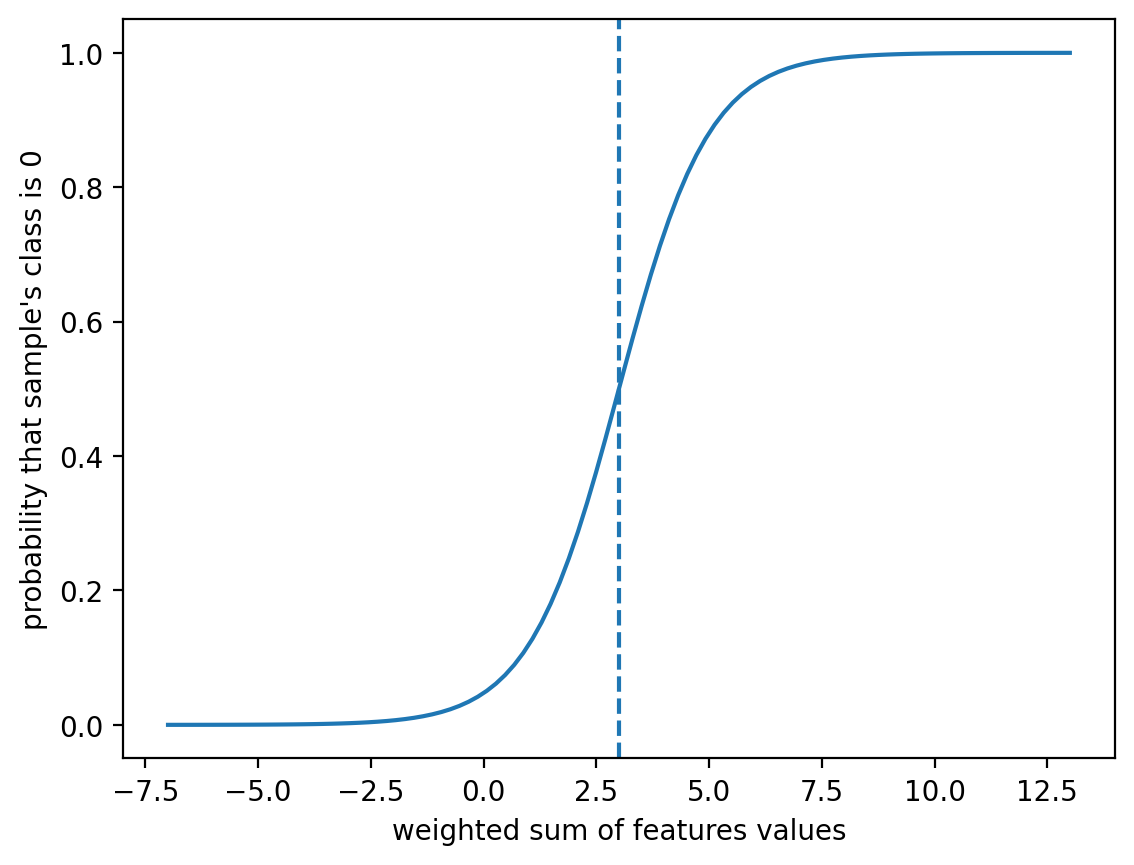

In [10]:
# classification threshold
threshold = 3
# results of weighted sum (around the threshold)
weighted_sum = np.linspace(-10 + threshold, 10 + threshold, 100)
# logistic function
plt.plot(weighted_sum, 1 / (1 + np.exp(threshold - weighted_sum)))
plt.axvline(x=threshold, linestyle="--")

plt.ylabel("probability that sample's class is 0")
plt.xlabel("weighted sum of features values");

### Demonstration

Let's use a (almost) line-separable dataset:

In [11]:
import pandas as pd

df = pd.read_csv("data/line_separable_2d.csv")
df.head(2)

x         y  label
0 -3.252709 -0.821378      0
1 -3.816946 -0.906188      0

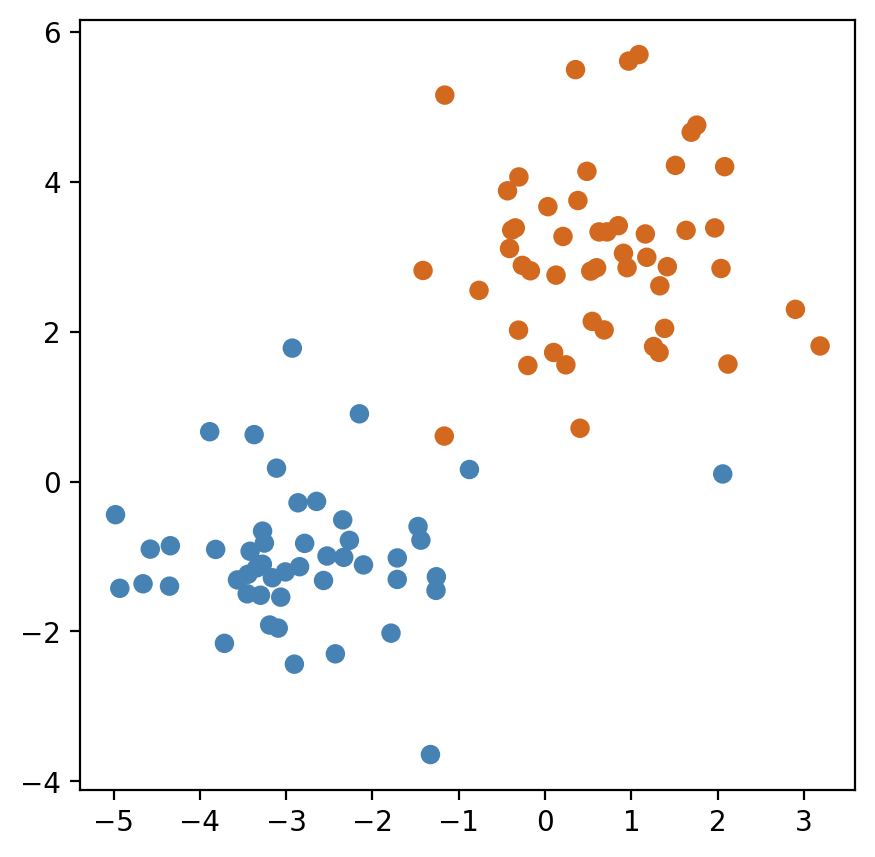

In [12]:
features_2d = df.loc[:, ("x", "y")]
labelv = df["label"]

plt.figure(figsize=(5, 5))
plt.scatter(features_2d.iloc[:, 0], features_2d.iloc[:, 1], color=samples_color(labelv));

You can find the Logistic Regression method in the `sklearn.linear_model` module.

In scikit-learn `LogisticRegression` the regularization weight is passed here in "inverse", as a classification weight parameter `C` (default `1`), meaning that it multiplies the classification loss, not the regularization penalty:

$$\text{cost} =  \text{C}\cdot\text{classification_loss} + \text{regularization_penalty}$$


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=0)

classifier = LogisticRegression(C=1, random_state=0)
classifier.fit(X_train, y_train)
print("train score: {:.2f}%".format(100 * classifier.score(X_train, y_train)))
print("test score: {:.2f}%".format(100 * classifier.score(X_test, y_test)))

train score: 97.33%
test score: 96.00%


Feature weights are available via `.coef_` attribute, whereas threshold is the negated `.intercept_` attribute. With these we can plot separation line.

Let's see how does it look like and what happens if we put more weight on the classification loss (increase `C` parameter).

feature weights: [[0.55729655 1.9409654 ]]


With C=100

train score: 100.00%
test score: 92.00%
feature weights: [[1.00188452 9.59491678]]


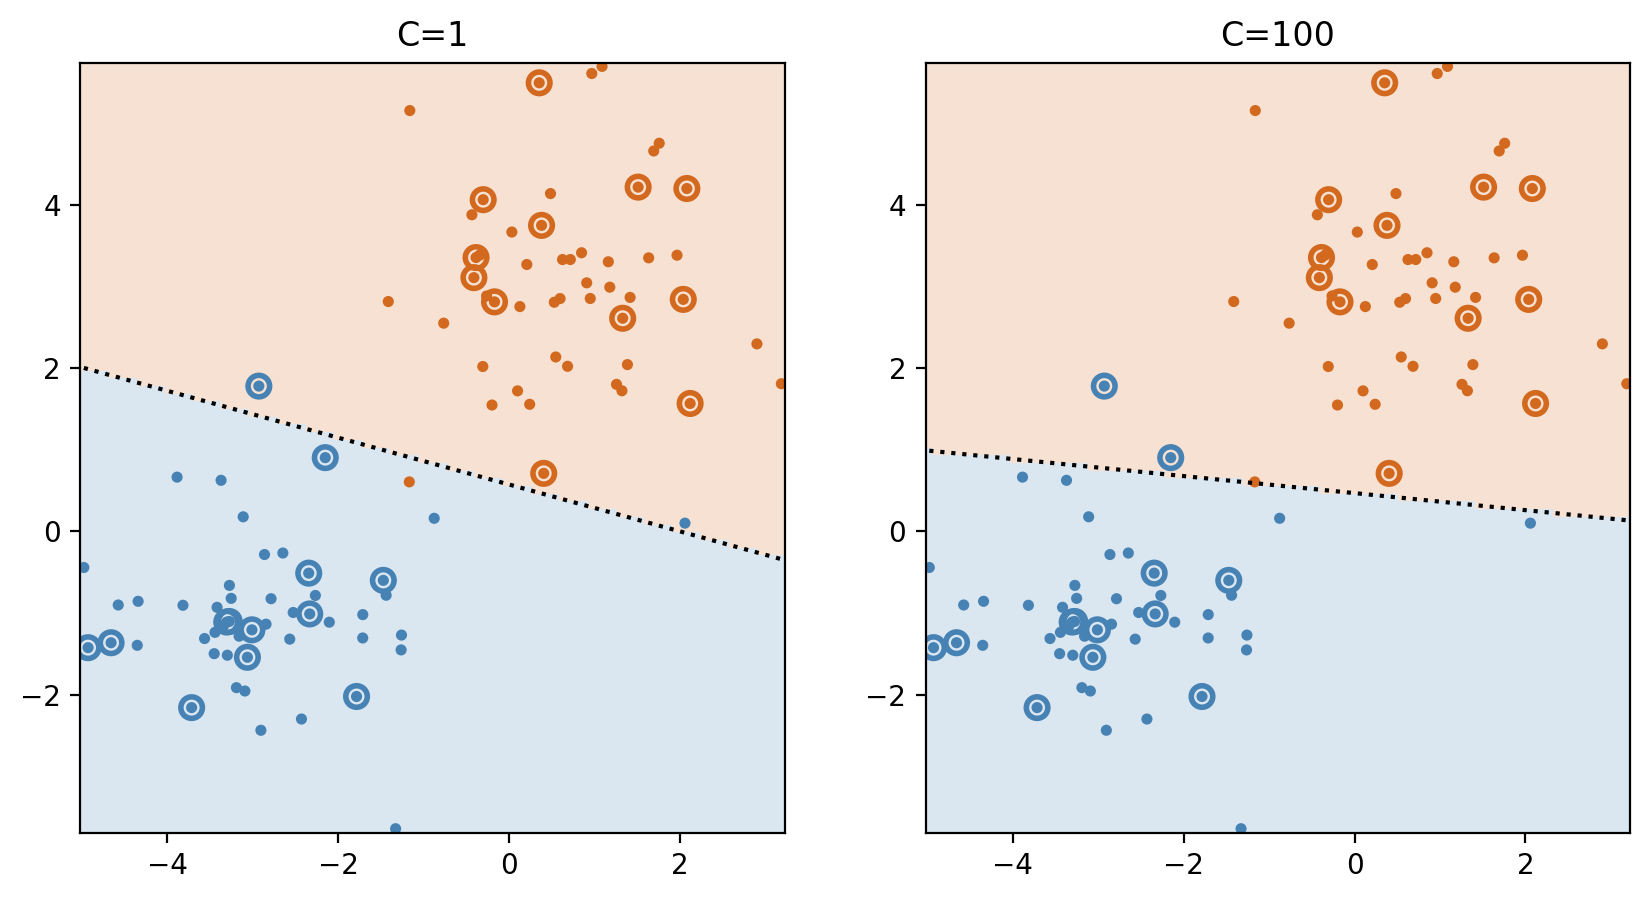

In [14]:
fig, ax_arr = plt.subplots(ncols=2, nrows=1, figsize=(2 * 5, 5))

plot_decision_surface(
    features_2d,
    labelv,
    classifier,
    test_features_2d=X_test,
    test_labels=y_test,
    plt=ax_arr[0],
    title="C=1",
)

print("feature weights:", classifier.coef_)


def plot_separation_line(features_2d, linear_classifier, plt=plt):
    """Plot a separation line for 2D dataset"""

    assert hasattr(linear_classifier, "coef_")

    w = linear_classifier.coef_[0]
    b = -linear_classifier.intercept_  # NOTE: intercept = negative threshold

    # separation line: w[0] * x + w[1] * y - b == 0
    feat_x = features_2d.iloc[:, 0]
    x = np.linspace(np.min(feat_x), np.max(feat_x), 2)
    y = (b - w[0] * x) / w[1]
    plt.plot(x, y, color="k", linestyle=":")


plot_separation_line(features_2d, classifier, plt=ax_arr[0])


print()
print()
print("With C=100")
print()

classifier = LogisticRegression(C=100, random_state=0)
classifier.fit(X_train, y_train)
print("train score: {:.2f}%".format(100 * classifier.score(X_train, y_train)))
print("test score: {:.2f}%".format(100 * classifier.score(X_test, y_test)))
print("feature weights:", classifier.coef_)

plot_decision_surface(
    features_2d,
    labelv,
    classifier,
    test_features_2d=X_test,
    test_labels=y_test,
    plt=ax_arr[1],
    title="C=100",
)
plot_separation_line(features_2d, classifier, plt=ax_arr[1])

### Exercise section

1. Why does the test score drop when we penalize more misclassifications?
2. For the higher dimensional beers dataset experiment with both `C` and `penalty` parameters of the linear regression classfier. Compare scores and the resulting weights. What does the `l1` penalty do? What is the sweet spot of the "inverse regularization" `C`?
  

In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("data/beers.csv")
features = df.iloc[:, :-1]
labelv = df.iloc[:, -1]

C_values = [0.01, 0.1, 1, 10, 100, 1000]
penalty_values = ["l1", "l2"]
# ...

<div class="alert alert-block alert-info">

<p><i class="fa fa-info-circle"></i>&nbsp;
The <strong>classification loss</strong> in logistic regression is a so called <em>negative-log likelihood</em>, i.e. a negative logarithm of the logistic probability above:
<p/>
    
<p>
$$ \text{classification_loss} = -\log(p(x^k; p^k)) = \log{\left(1+\exp{\left(y^k\left(b - \sum_{i=1}^{n} w_i x_i^k\right)\right)}\right)}$$
<p/>

<p>
where $y^k$ is -1 or 1, representing class of $k$-th sample from the training data, corresponding, respectively, to class below and above the threshold (the separation line).

The $+/-$ sign for the class penalizes missclassifications. If sample is below the threshold $\sum_{i=1}^{n} w_i x_i^k < b$ and have the correct class $y^k = -1$, then we have $\exp{\left(\text{negative value}\right)}$ giving small loss. In case of misclassification $\exp{\left(\text{positive value}\right)}$ gives a much bigger loss.
</p>
</div>

<div class="alert alert-block alert-info">
<p><i class="fa fa-info-circle"></i>&nbsp;
The <strong>reqularization penalty</strong> in logistic regression is a <em>norm of the learnt weights</em>, denoted as:

<p>
$$\text{regularization_penalty} = \left\lVert w \right\rVert_p$$
</p>

<p>
Using <em>L1 norm</em> ($p=1$, Manhattan distance from origin, which is sum of absolute weight values) is know for finding sparse solutions, i.e. eliminating features (weight equal to 0) when they are have low significance. With the default <em>L2 norm</em> ($p=2$, Euclidian distance from origin, which is square root of sum of squared weight values), weights of insignificant features would have small non-zero values instead.
</p>

<p>
In <code>LogisticRegression</code> class, <code>penalty</code> parameter allows to specify type of norm to use.
</p>

<p>
Note that any solution weights and its threshold can be scaled to give the same result. Thus the regularization penalty not only prevents overfitting but also ensures a unique solution.
</p>

</div>

## Linear SVM

Support-Vector Machine (SVM) classifier tries to separate two classes with a line by **finding data points (support vectors) lying closest to the separation plane**. These points determine separation plane (weights and threshold/intercept).

The weights are learned such that the **margin between support vectors of different classes is maximized**.

<table>
    <tr><td><img src="./images/svm_margin.png" width=400px></td></tr>
    <tr><td><center><sub>Source: <a href="https://en.wikipedia.org/wiki/Support-vector_machine">https://en.wikipedia.org/wiki/Support-vector_machine</a></sub></center></td></tr>
</table>

Like in linear regression the classification is based on a weighted sum of the features (and margin maximization corresponds to minimization of the regularization penalty). 

Analogously to the Nearest Neighbors method the data points (support vectors) decide the class of a new data sample.

### Demonstration

Let's try it out on the line-separable dataset.

You will find the SVM method in the `sklearn.svm` module.

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC


df = pd.read_csv("data/line_separable_2d.csv")
features_2d = df.loc[:, ("x", "y")]
labelv = df["label"]

X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=0)

classifier = LinearSVC(C=1)
classifier.fit(X_train, y_train)
print("train score: {:.2f}%".format(100 * classifier.score(X_train, y_train)))
print("test score: {:.2f}%".format(100 * classifier.score(X_test, y_test)))

train score: 98.67%
test score: 96.00%


Again, let's see how does the separation line look like here and what happens if we put more weight on the classification loss (increase `C` parameter).

feature weights: [[0.15856439 1.01077748]]


With C=100

train score: 100.00%
test score: 92.00%
feature weights: [[0.81571325 8.45145608]]


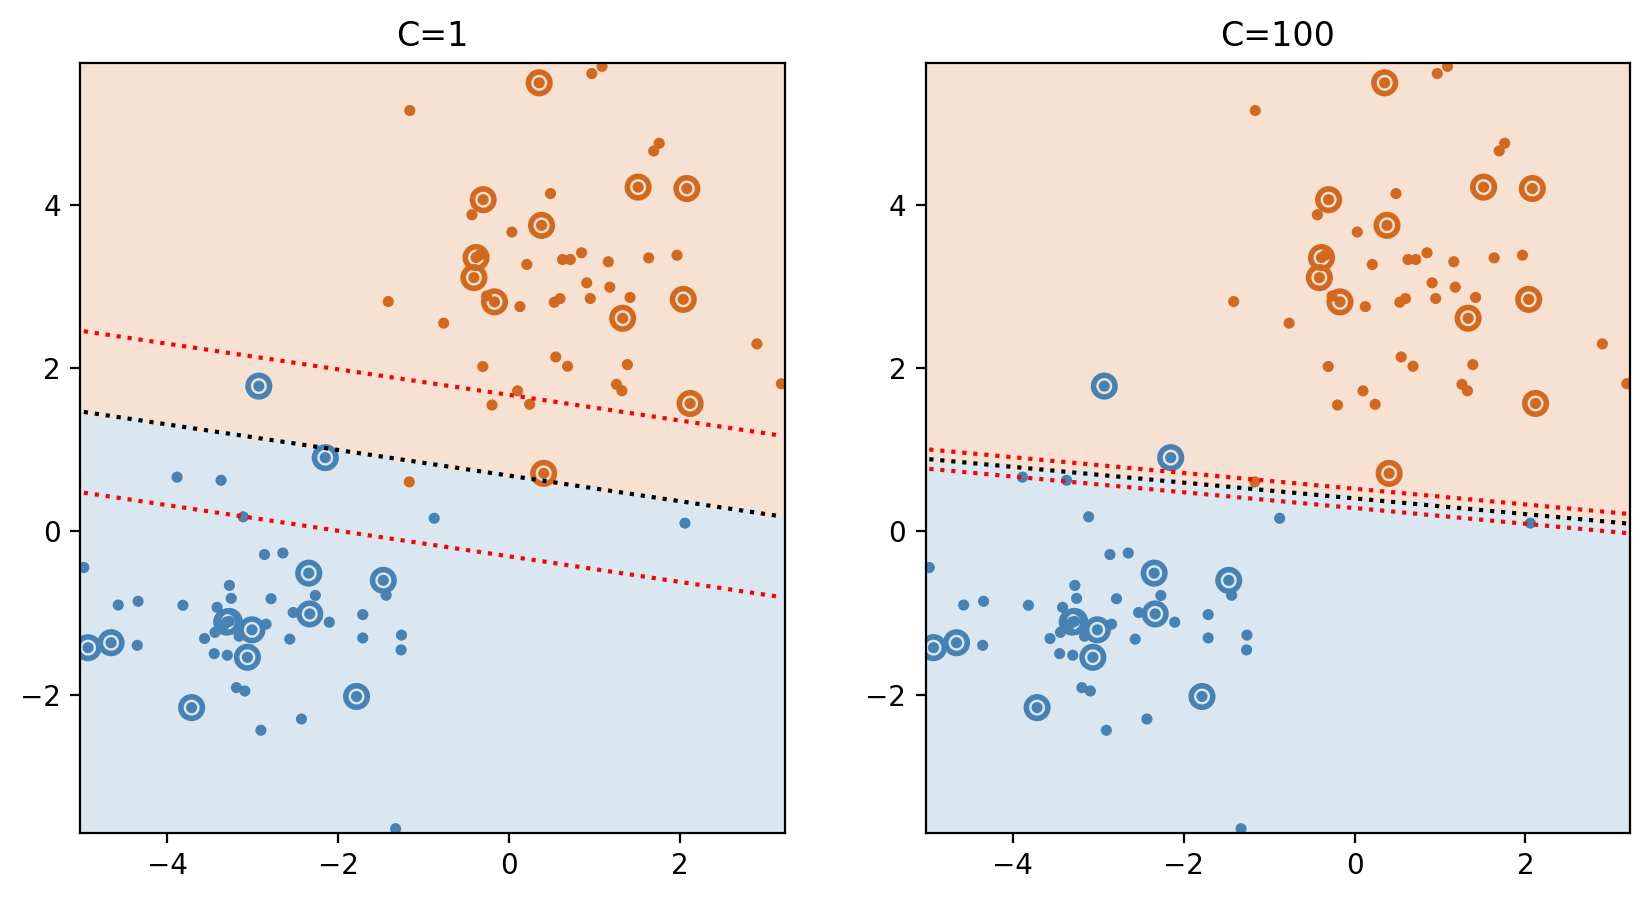

In [19]:
fig, ax_arr = plt.subplots(ncols=2, nrows=1, figsize=(2 * 5, 5))

plot_decision_surface(
    features_2d,
    labelv,
    classifier,
    test_features_2d=X_test,
    test_labels=y_test,
    plt=ax_arr[0],
    title="C=1",
)

print("feature weights:", classifier.coef_)


def plot_margins(features_2d, linear_classifier, plt=plt):
    """Plot a separation line and margin lines for 2D dataset"""

    assert hasattr(linear_classifier, "coef_")

    w = linear_classifier.coef_[0]
    b = -linear_classifier.intercept_  # NOTE: intercept = negative threshold

    # separation line: w[0] * x + w[1] * y - b == 0
    feat_x = features_2d.iloc[:, 0]
    x = np.linspace(np.min(feat_x), np.max(feat_x), 2)
    y = (b - w[0] * x) / w[1]
    plt.plot(x, y, color="k", linestyle=":")

    # margin lines: w[0] * x + w[1] * y - b == +/-1
    y = ((b - 1) - w[0] * x) / w[1]
    plt.plot(x, y, color="r", linestyle=":")
    y = ((b + 1) - w[0] * x) / w[1]
    plt.plot(x, y, color="r", linestyle=":")


plot_margins(features_2d, classifier, plt=ax_arr[0])


print()
print()
print("With C=100")
print()

# higher C = more narrow ("harder") margin
# Note: increase max iterations 50x for solver's convergence
classifier = LinearSVC(C=100, max_iter=50000)
classifier.fit(X_train, y_train)
print("train score: {:.2f}%".format(100 * classifier.score(X_train, y_train)))
print("test score: {:.2f}%".format(100 * classifier.score(X_test, y_test)))
print("feature weights:", classifier.coef_)

plot_decision_surface(
    features_2d,
    labelv,
    classifier,
    test_features_2d=X_test,
    test_labels=y_test,
    plt=ax_arr[1],
    title="C=100",
)
plot_margins(features_2d, classifier, plt=ax_arr[1]);

Why are there **training data samples within the margin**?

This is because the scikit-learn `LinearSVC` implementation by default uses so called **"soft margins"**, ("hinge" loss function in `loss` parameter). They allow support vectors to lie within the -1, 1 margin (with appropriately lower weights than -1, 1).

You can control "softness" or "hardness" of classification loss by, respectively, decreasing or increasing its weight (parameter `C` of the `LinearSVC` class).

### Exercise section

1. It looks like we did train our classifier "perfectly" with "harder" margins. Why is the score then lower then previously?
2. For the higher dimensional beers dataset experiment with both `C` and `penalty` parameters of the linear SVM classfier (note: set `dual=False` to work with `penalty='l1'`). Compare scores and the resulting weights.
  

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


df = pd.read_csv("data/beers.csv")
features = df.iloc[:, :-1]
labelv = df.iloc[:, -1]

C_values = [0.01, 0.1, 1, 10, 100, 1000]
penalty_values = ["l1", "l2"]

# ...

## Kernel based SVM

### Dealing with not linearily-separable data

Data is usually not at all linearily separable.

Let's revisit the "circle" data.

In [23]:
import pandas as pd


df = pd.read_csv("data/circle.csv")
df.head(2)

x         y  label
0 -0.501840  1.802857  False
1  0.927976  0.394634   True

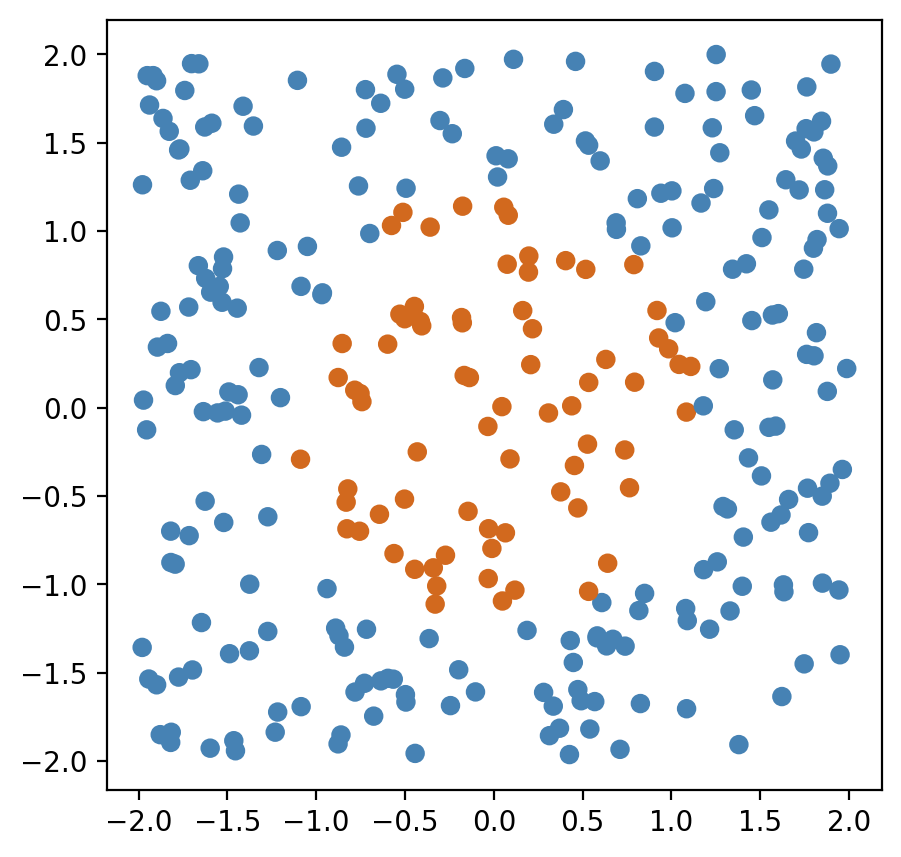

In [24]:
features_2d = df.loc[:, ("x", "y")]
labelv = df["label"]

plt.figure(figsize=(5, 5))
plt.scatter(features_2d.iloc[:, 0], features_2d.iloc[:, 1], color=samples_color(labelv));

Linear methods like SVM fail in such cases to learn the underlying pattern:

score: 81.33%
feature weights: [[-0.00749024 -0.0153554 ]]


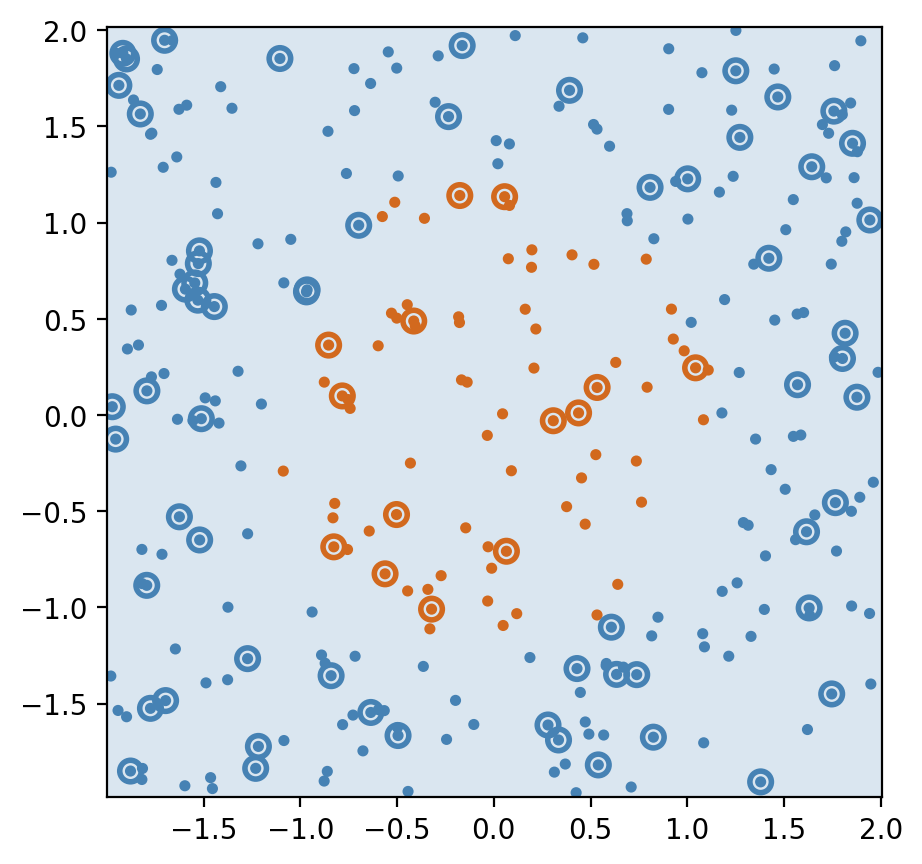

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC


X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=0)

# Note: increase max iterations 500x (!!) for solver's convergence
classifier = LinearSVC(C=1000, max_iter=500000)
classifier.fit(X_train, y_train)
print("score: {:.2f}%".format(100 * classifier.score(X_test, y_test)))

plt.figure(figsize=(5, 5))
plot_decision_surface(
    features_2d,
    labelv,
    classifier,
    test_features_2d=X_test.iloc[:, :2],
    test_labels=y_test,
)

print("feature weights:", classifier.coef_)

As done in previous scripts, we can solve this issue by engineer a new feature: a distance to the center $(0, 0)$.

Effectively, we're mapping each 2D data sample $(x,y)$ into a higher-dimensional 3D features space $(x, y, x^2+y^2)$ to learn a linear classifier therein:

In [26]:
from sklearn.preprocessing import FunctionTransformer


# np array in and out
def phi(arr_2d):
    xv = arr_2d[:, 0]
    yv = arr_2d[:, 1]
    distv = xv ** 2 + yv ** 2
    return np.vstack([xv, yv, distv]).T


# `validate=True` converts to np array
add_distance_to_zero = FunctionTransformer(phi, validate=True)

features_3d = pd.DataFrame(
    add_distance_to_zero.transform(features_2d), columns=["x", "y", "x^2 + y^2"]
)
features_3d.head(3)

/Users/franziskaoschmann/miniconda3/envs/mlws_local/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


x         y  x^2 + y^2
0 -0.501840  1.802857   3.502137
1  0.927976  0.394634   1.016875
2 -1.375925 -1.376022   3.786607

Linear SVM classifier should work fine now, putting weight mostly on our new feature which is able alone to discriminate between the classes:

score: 97.33%
feature weights: [[-0.06440867 -0.09749599 -1.95658989]]


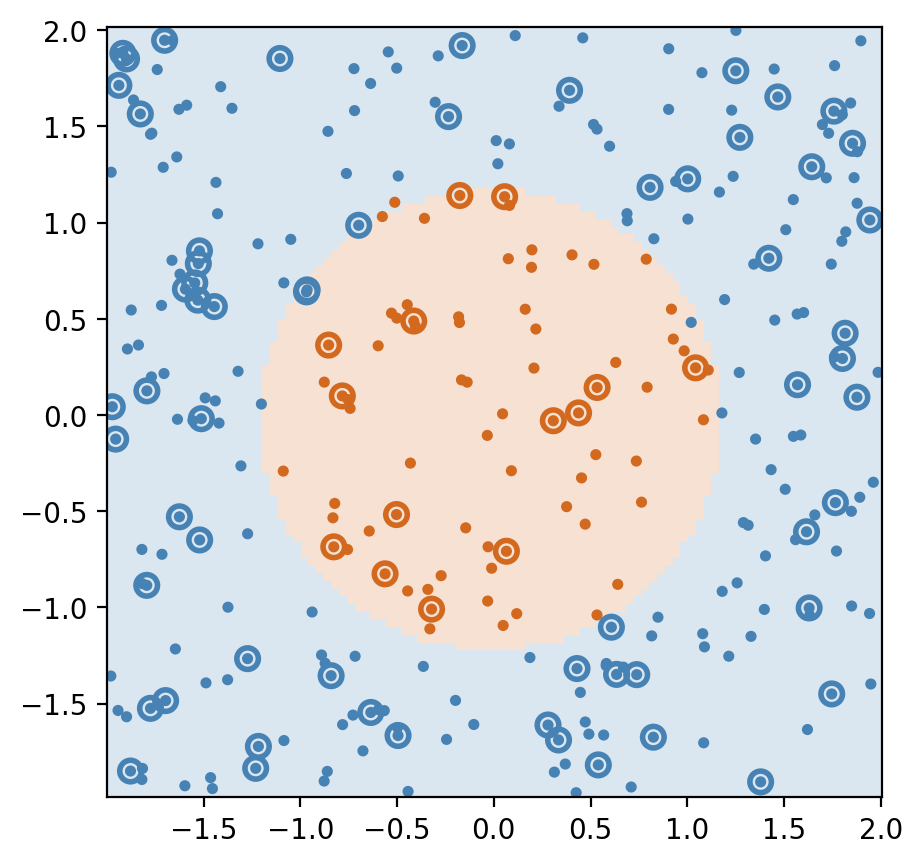

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC


X_train, X_test, y_train, y_test = train_test_split(features_3d, labelv, random_state=0)

classifier = LinearSVC()
classifier.fit(X_train, y_train)
print("score: {:.2f}%".format(100 * classifier.score(X_test, y_test)))

plt.figure(figsize=(5, 5))
plot_decision_surface(
    features_2d,
    labelv,
    classifier,
    preprocessing=add_distance_to_zero,
    test_features_2d=X_test.iloc[:, :2],
    test_labels=y_test,
)

print("feature weights:", classifier.coef_)

### Implicit solution: the kernel trick

The kernel SVM method avoids explicit construction of mapping of the not linearily-separable data, and instead starts with a so called *similarity measure* $K$.

One examples is a Radial Basis Function (RBF)

$$
K\left(x,y\right) = e^{-\left(\gamma ||x - y||\right)^2}
$$

It is a Gaussian-shaped similarity measure that returns `1` for the same points and declines exponentially to `0` with distance increasing between points, with a *decline rate* controlled by the $\gamma$ parameter.


Using the so called **kernel trick**, SVC uses such similarity measure (kernel) as if mapping to higher dimensional features space, without actually applying the mapping. Instead, the similarity is used directly for computing cost function as in the linear SVM method.


<table>
    <tr><td><a href='https://imgflip.com/i/7vge4m'><img src="./images/7vge4m.jpg" width=100%/></a><br/><a href='https://imgflip.com/gif-maker'> via Imgflip GIF Maker</a> </td></tr>
</table>



<div class="alert alert-block alert-info">
<p><i class="fa fa-info-circle"></i>&nbsp;
A mapping to higher dimensions $\phi(x)$ is costly to compute and store for the whole dataset. However, linear SVM just needs to know values of sums of mulitplied feature values between data sample and support vectors, called <em>dot-product</em>. Hence, kernel SVM does the <strong>kernel trick</strong> by using a pre-selected kernel function and by assuming $K(x^1, x^2) = \phi(x^1)\cdot\phi(x^2)$, i.e. such that it gives values as if the similarity between samples $x^1$ and $x^2$ was computed after the mapping, but without actual mapping.
</p>
</div>

### Demonstration

The default kernel for `SVC` is the Radial Basis Function (RBF). The `gamma` parameter of `SVC` controls the decline rate (higher value = slower decline).

train score: 98.67%
test score: 96.00%
#support vectors: [130  51]


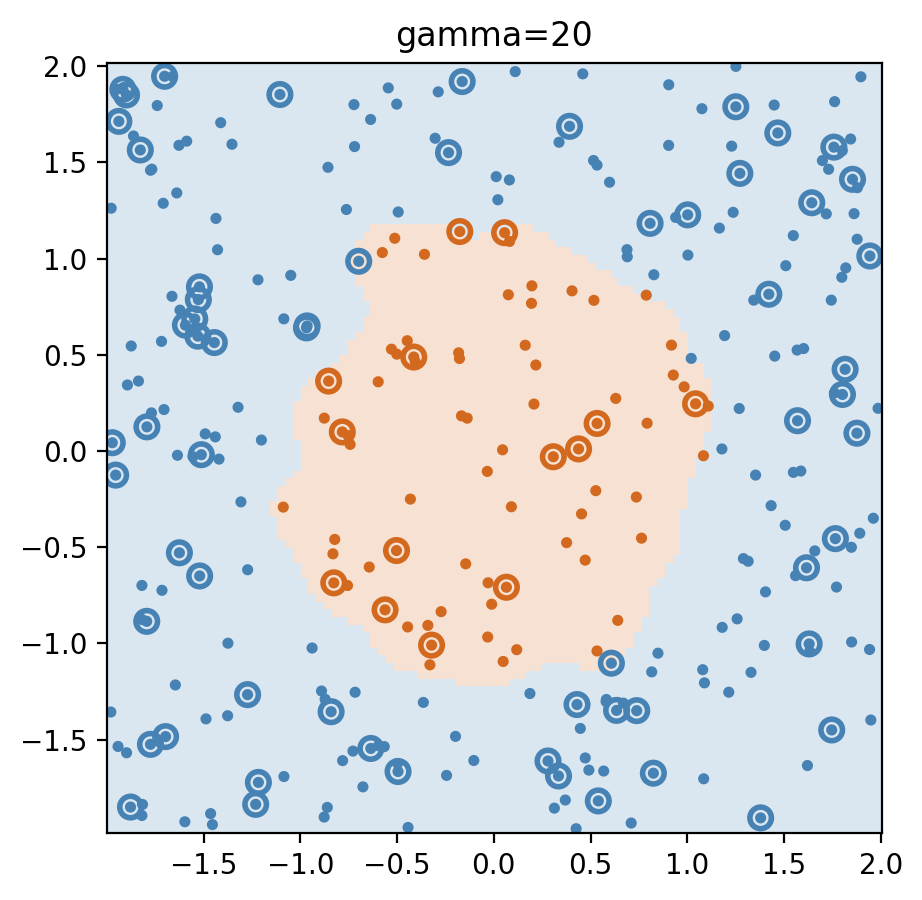

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=0)

# specify kernel and gamma
classifier = SVC(kernel="rbf", gamma=20)
classifier.fit(X_train, y_train)

print("train score: {:.2f}%".format(100 * classifier.score(X_train, y_train)))
print("test score: {:.2f}%".format(100 * classifier.score(X_test, y_test)))

# NOTE: mapping is implicit - feature weights are not there anymore (coef_);
#       instead we have only support vectors (and their weights; dual_coef_).
#
# Let's just see how many of samples are used as support vectors for each class.
print("#support vectors:", classifier.n_support_)

plt.figure(figsize=(5, 5))
plot_decision_surface(
    features_2d,
    labelv,
    classifier,
    test_features_2d=X_test,
    test_labels=y_test,
    title="gamma=20",
)

But this "circle" did not really turn out nice. The `gamma` parameter controls both size and *smoothness* of the decision surface.

**`gamma` parameter is crucial for a good performance!**

<div class="alert alert-block alert-warning">

<p><i class="fa fa-warning"></i>&nbsp;
Before using <strong>kernel SVM</strong> you need to <strong>scale (normalize) your features first</strong>. This is because it relies on the "similarity"/"distance" function. Otherwise, kernel SVM might not work well.</p>
    
</div>

### Exercise section

1. Which gamma value to pick for the circle dataset?
2. For both XOR and beers datasets try different values of the `kernel` parameter. Which kernels do work?

In [29]:
# 1. Which gamma value to pick?
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


df = pd.read_csv("data/circle.csv")
features_2d = df.loc[:, ("x", "y")]
labelv_xor = df["label"]

gammas = [
    0.05,
    0.5,
    5,
    50,
    "scale",
]

# ...

In [30]:
# 2. Which kernels do work?
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


df_xor = pd.read_csv("data/xor.csv")
features_xor = df.iloc[:, :-1]
labelv_xor = df.iloc[:, -1]

df_beers = pd.read_csv("data/beers.csv")
features_beers = df.iloc[:, :-1]
labelv_beers = df.iloc[:, -1]

kernels = [
    "linear",
    "poly",
    "rbf",
    "sigmoid",
]

# ...

## Few words about assigning weights to the classes

Some of the scikit-learn classifiers, such as SVM, provide a **`class_weight` parameter** which allows to assign weights to classes according to their importance. Do use it when:

* some misclassifications are more important to avoid than others, e.g. classifing an actual email as a spam is worse than the other way around, or
* your have **imbalanced data**, i.e. you have a large amount of samples for one class and much fewer observations for other classes.

<div class="alert alert-block alert-info">
<i class="fa fa-info-circle"></i>
In case of the imbalanced data, if the learning method does not support weight, you can always over/under-sample the under/over-represented classes (cf. <a href="https://imbalanced-learn.org/en/stable/introduction.html">the <code>imblearn</code> external module to be used with scikit-learn</a>).
</div>


### Demonstration

Let's imbalance the circle dataset and pick only 5 samples from the circle interior class:

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.read_csv("data/circle.csv")
labelv = df["label"]

# circle interior is the `True` class
idx_c1 = df.index[labelv == True][:5]  # TAKE FIVE
idx_c2 = df.index[labelv == False]

df = pd.concat([df.iloc[idx_c1], df.iloc[idx_c2]])
df.head(8)

x         y  label
1   0.927976  0.394634   True
4   0.404460  0.832290   True
8  -0.783031  0.099026   True
9  -0.272220 -0.835083   True
11 -0.831421 -0.534553   True
0  -0.501840  1.802857  False
2  -1.375925 -1.376022  False
3  -1.767666  1.464705  False

Let's now train `SVC` in three variants:

1. w/o class weights,
2. w/ manually assigned weights,
3. w/ weights proportional to number of samples in each class

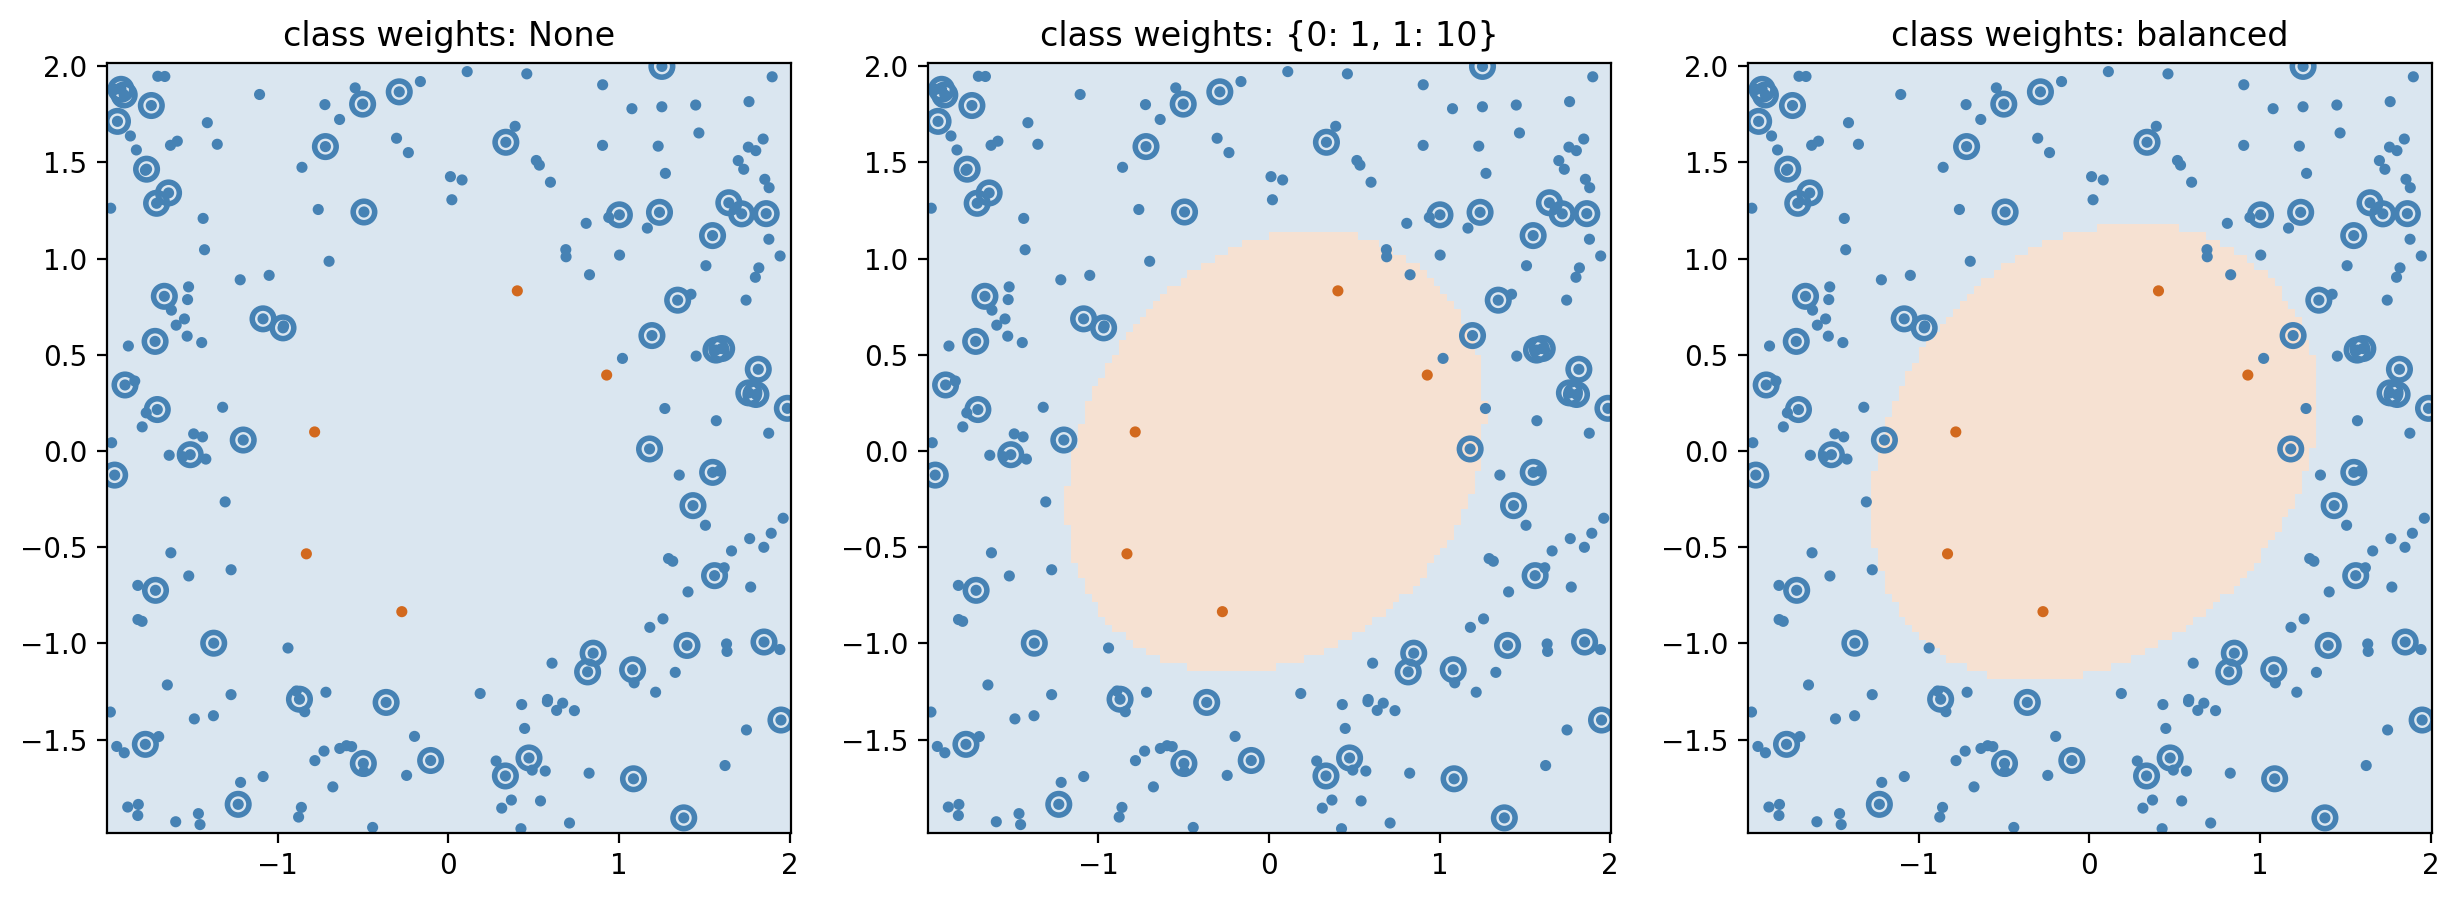

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

labelv = df["label"]
features_2d = df.loc[:, ("x", "y")]

X_train, X_test, y_train, y_test = train_test_split(features_2d, labelv, random_state=0)


class_weights = [
    None,  # default: no weights
    {0: 1, 1: 10},  # explicitly assigned weights as {class_number: class_weight} dict
    "balanced",  # according to nr of samples in each class
]


n_class_weights = len(class_weights)
fig, ax_arr = plt.subplots(ncols=n_class_weights, figsize=(5 * n_class_weights, 5))

for i, class_weight in enumerate(class_weights):

    classifier = SVC(class_weight=class_weight)
    classifier.fit(X_train, y_train)

    plot_decision_surface(
        features_2d,
        labelv,
        classifier,
        test_features_2d=X_test,
        test_labels=y_test,
        title="class weights: {}".format(class_weight),
        plt=ax_arr[i],
    )

Copyright (C) 2019-2022 ETH Zurich, SIS ID